# Add Titles and introductory info here

## Collect Data:

In [1]:
# Import dependencies:

import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
from config import api_key
import time   #used for time.sleep

In [2]:
# Generate a random list of 500 unique cities with a reasonably even distribution across the globe

# Set a range for lat and lng that includes the whole Earth
# latitude range is -90 to 90, longitude range is -180 to 180
lats = []
longs = []

lats = np.random.uniform(-90, 90, 100)
longs = np.random.uniform(-180, 180, 100)

#print(lats)
#print(longs)

In [4]:
# zip lists together to form coordinates
lat_long = zip(lats, longs)

In [5]:
# Use citipy to find cities near coordinates

#Import citipy
from citipy import citipy

cities = []
countries = []

for lat_long in lat_long:
    city = citipy.nearest_city(lat_long[0], lat_long[1]).city_name
    country = citipy.nearest_city(lat_long[0], lat_long[1]).country_code
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)
        countries.append(country)

# Print the city count to confirm sufficient count
print(len(cities))
print(len(countries))

81
81


In [6]:
# Format data for improved legibility
cities = [city.title() for city in cities]
countries = [country.upper() for country in countries]

In [7]:
# Build dataframe to hold data
weather_df = pd.DataFrame({"Cities" : cities, "Countries" : countries})
weather_df.head()

,Cities,Countries
0,Ngukurr,AU
1,Ulundurpettai,IN
2,Chokurdakh,RU
3,Cockburn Town,BS
4,Biltine,TD


In [8]:
# Check for NaNs
weather_df.isnull().sum()

Cities       0
Countries    0
dtype: int64

In [9]:
# Add places to hold data for each city

weather_df["Latitude"] = ""
weather_df["Longitude"] = ""
weather_df["Max Temperature (F)"] = ""
weather_df["Humidity (%)"] = ""
weather_df["Cloudiness"] = ""
weather_df["Wind Speed (mph)"] = ""
weather_df["Date"] = ""
weather_df.head()

,Cities,Countries,Latitude,Longitude,Max Temperature (F),Humidity (%),Cloudiness,Wind Speed (mph),Date
0,Ngukurr,AU,,,,,,,
1,Ulundurpettai,IN,,,,,,,
2,Chokurdakh,RU,,,,,,,
3,Cockburn Town,BS,,,,,,,
4,Biltine,TD,,,,,,,


In [10]:
# Use OpenWeather to get weather data for generated list of cities, test on one city

base_url = "http://api.openweathermap.org/data/2.5/weather?"
city_name = "Minneapolis"
country_code = "US"
query_url = f"{base_url}q={city_name},{country_code}&appid={api_key}&units=imperial"
#print(query_url) - test url worked
#minneapolis_weather = requests.get(query_url).json()
#minneapolis_weather

In [11]:
# Build a for loop to use the city names to call the OpenWeather API
# Test to ensure that the city has data, otherwise skip
# Generate a print log for each city as it is being processed

my_params = {"appid" : api_key, "units" : "imperial"}

for index, row in weather_df.iterrows():
    base_url = "http://api.openweathermap.org/data/2.5/weather?"
    city = row["Cities"]
    country = row["Countries"]
    
    my_params['q'] = f'{city},{country}'
    
    #make request
    cities_weather = requests.get(base_url, params=my_params).json()
    print(index, city)
    try:
        weather_df.loc[index, "Latitude"] = cities_weather["coord"]["lat"]
    except KeyError:
        weather_df.loc[index, "Latitude"] = np.nan
        print("skip")
        continue
       
    weather_df.loc[index, "Longitude"] = cities_weather["coord"]["lon"]
    weather_df.loc[index, "Max Temperature (F)"] = cities_weather["main"]["temp_max"]
    weather_df.loc[index, "Humidity (%)"] = cities_weather["main"]["humidity"]
    weather_df.loc[index, "Cloudiness"] = cities_weather["clouds"]["all"]
    weather_df.loc[index, "Wind Speed (mph)"] = cities_weather["wind"]["speed"]
    weather_df.loc[index, "Date"] = cities_weather["dt"]
    
    time.sleep(1)
        

0 Ngukurr
skip
1 Ulundurpettai
skip
2 Chokurdakh
3 Cockburn Town
4 Biltine
5 Rikitea
6 Lavrentiya
7 Sitka
8 Vaini
9 Nanortalik
10 Brae
11 Kapaa
12 Kisesa
13 Barentsburg
skip
14 Albany
15 Hermanus
16 Saskylakh
17 Aguimes
18 Dikson
19 Butaritari
20 Guerrero Negro
21 Ostrovnoy
22 Ribeira Grande
23 Mataura
skip
24 Busselton
25 Ushuaia
26 Baykit
27 East London
28 Cap Malheureux
29 Marv Dasht
skip
30 Russellville
31 Provideniya
32 Portree
33 Nikolskoye
34 Bluff
35 Porto Santo
36 Ancud
37 Jamestown
38 Upernavik
39 Wanning
40 Salym
41 Atikokan
42 Airai
skip
43 Margate
44 Roanoke Rapids
45 Punta Arenas
46 Mackay
47 Puerto Ayora
48 Nizhneyansk
skip
49 Tazovskiy
50 Severo-Kurilsk
51 Balakhninskiy
52 Agadez
53 Shamsabad
54 Lazaro Cardenas
55 Erenhot
56 Khasan
57 Vaitupu
skip
58 Grand River South East
skip
59 Roald
60 Prince Rupert
61 Bredasdorp
62 Tuktoyaktuk
63 Grindavik
64 Kalmunai
65 Vila Velha
66 Georgetown
67 Sakakah
68 Coihaique
69 Faya
skip
70 Illoqqortoormiut
skip
71 Victoria
72 Intipuca
7

In [12]:
#Drop rows with missing values
weather_df.dropna(inplace=True)
weather_df.reset_index(drop=True, inplace=True)
len(weather_df)

70

In [15]:
# Check for humidity outliers
weather_df["Humidity (%)"].max()

100

In [16]:
weather_df.head()

,Cities,Countries,Latitude,Longitude,Max Temperature (F),Humidity (%),Cloudiness,Wind Speed (mph),Date
0,Chokurdakh,RU,70.6333,147.917,-12.51,86,0,10.16,1612831065
1,Cockburn Town,BS,24.0333,-74.5167,77,83,0,16.02,1612831066
2,Biltine,TD,14.5333,20.9167,65.21,24,46,13.62,1612830897
3,Rikitea,PF,-23.1203,-134.969,77.97,69,18,3.22,1612831068
4,Lavrentiya,RU,65.5833,-171,-3.73,84,100,11.12,1612831069


In [17]:
#Clean up formatting
weather_df = weather_df.convert_dtypes()
weather_df = weather_df.round({"Latitude": 2,"Longitude": 2, "Max Temperature (F)": 1, "Wind Speed (mph)": 1})
weather_df.head()

,Cities,Countries,Latitude,Longitude,Max Temperature (F),Humidity (%),Cloudiness,Wind Speed (mph),Date
0,Chokurdakh,RU,70.63,147.92,-12.5,86,0,10.2,1612831065
1,Cockburn Town,BS,24.03,-74.52,77.0,83,0,16.0,1612831066
2,Biltine,TD,14.53,20.92,65.2,24,46,13.6,1612830897
3,Rikitea,PF,-23.12,-134.97,78.0,69,18,3.2,1612831068
4,Lavrentiya,RU,65.58,-171.00,-3.7,84,100,11.1,1612831069


In [18]:
# Save a CSV file containing all weather data

weather_df.to_csv("cities_weather.csv", encoding='utf-8', index=False)

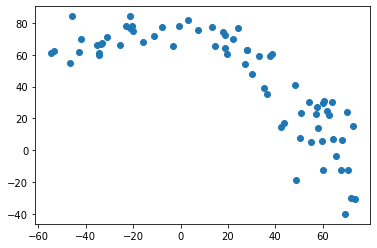

In [19]:
# Make a scatter plot to show relationship of temperature v latitude

x = weather_df["Latitude"]
y = weather_df["Max Temperature (F)"]

temp_plt = plt.scatter(x, y, marker="o")

plt.show()

# Save plot as a PNG file

## After each plot, add a sentence or two explaining what the code is analyzing.

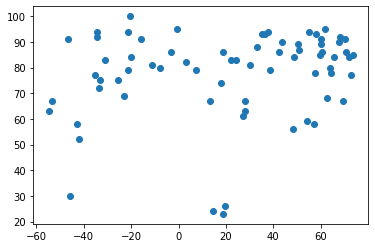

In [20]:
# Make a scatter plot to show the relationship of humidity v latitude

x = weather_df["Latitude"]
y = weather_df["Humidity (%)"]

temp_plt = plt.scatter(x, y, marker="o")

plt.show()

# Save plot as a PNG file

## After each plot, add a sentence or two explaining what the code is analyzing.

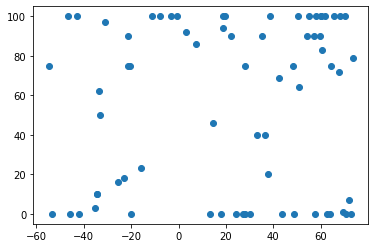

In [21]:
# Make a scatter plot to show the relationship of cloudiness v latitude

x = weather_df["Latitude"]
y = weather_df["Cloudiness"]

temp_plt = plt.scatter(x, y, marker="o")

plt.show()

# Save plot as a PNG file

## After each plot, add a sentence or two explaining what the code is analyzing.

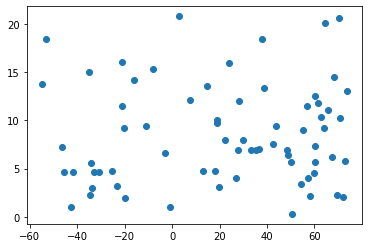

In [22]:
# Make a scatter plot to show the relationship of wind speed v latitude

x = weather_df["Latitude"]
y = weather_df["Wind Speed (mph)"]

temp_plt = plt.scatter(x, y, marker="o")

plt.show()

# Save plot as a PNG file

## After each plot, add a sentence or two explaining what the code is analyzing.

In [23]:
# The second requirement is to run linear regression on each relationship. This time, separate the plots 
# into Northern Hemisphere (greater than or equal to 0 degrees latitude) and Southern Hemisphere (less than 0 
# degrees latitude):

In [24]:
# Study data files


In [25]:
# Create bins and bin data

bins = [-90, 0, 90]
labels = ["south", "north"]
weather_df["Hemisphere"] = pd.cut(weather_df["Latitude"], bins=bins, labels=labels)
weather_df

,Cities,Countries,Latitude,Longitude,Max Temperature (F),Humidity (%),Cloudiness,Wind Speed (mph),Date,Hemisphere
0,Chokurdakh,RU,70.63,147.92,-12.5,86,0,10.2,1612831065,north
1,Cockburn Town,BS,24.03,-74.52,77.0,83,0,16.0,1612831066,north
2,Biltine,TD,14.53,20.92,65.2,24,46,13.6,1612830897,north
3,Rikitea,PF,-23.12,-134.97,78.0,69,18,3.2,1612831068,south
4,Lavrentiya,RU,65.58,-171.00,-3.7,84,100,11.1,1612831069,north
...,...,...,...,...,...,...,...,...,...,...
65,Verkhnedneprovskiy,RU,54.98,33.35,5.1,94,100,9.0,1612831141,north
66,Vardo,NO,70.37,31.11,24.2,91,100,20.6,1612831142,north
67,Erzin,RU,50.26,95.16,7.6,89,100,5.7,1612831143,north
68,Hualmay,PE,-11.10,-77.61,71.5,81,100,9.4,1612831144,south


In [27]:
# Split data into two frames, one for each hemisphere

weather_north_df = weather_df.loc[weather_df["Latitude"] > 0]
weather_north_df.reset_index(inplace=True, drop=True)
weather_north_df.head()

,Cities,Countries,Latitude,Longitude,Max Temperature (F),Humidity (%),Cloudiness,Wind Speed (mph),Date,Hemisphere
0,Chokurdakh,RU,70.63,147.92,-12.5,86,0,10.2,1612831065,north
1,Cockburn Town,BS,24.03,-74.52,77.0,83,0,16.0,1612831066,north
2,Biltine,TD,14.53,20.92,65.2,24,46,13.6,1612830897,north
3,Lavrentiya,RU,65.58,-171.00,-3.7,84,100,11.1,1612831069,north
4,Sitka,US,57.05,-135.33,23.0,58,90,11.5,1612831070,north


In [29]:
# Same for southern hemisphere

weather_south_df = weather_df.loc[weather_df["Hemisphere"] == "south"]
weather_south_df.reset_index(inplace=True, drop=True)
weather_south_df.head()

,Cities,Countries,Latitude,Longitude,Max Temperature (F),Humidity (%),Cloudiness,Wind Speed (mph),Date,Hemisphere
0,Rikitea,PF,-23.12,-134.97,78.0,69,18,3.2,1612831068,south
1,Vaini,TO,-21.20,-175.20,77.0,94,75,16.1,1612831071,south
2,Kisesa,TZ,-3.08,34.15,65.3,86,100,6.6,1612830851,south
3,Albany,AU,-35.02,117.89,66.2,77,3,15.0,1612831077,south
4,Hermanus,ZA,-34.42,19.23,60.0,92,10,5.6,1612831078,south


In [30]:
# Northern Hemisphere - Temperature (F) vs. Latitude
# Southern Hemisphere - Temperature (F) vs. Latitude

# define values for northern hemisphere
xn = weather_north_df["Latitude"]
yn = weather_north_df["Max Temperature (F)"]

#calculate regression
(slope_n, intercept_n, rvalue_n, pvalue_n, stderr_n) = linregress(xn, yn)
regress_n = xn * slope_n + intercept_n
line_eq_n = "y=" + str(round(slope_n,2)) + "x + " + str(round(intercept_n,2))
print(line_eq_n)

y=-1.39x + 94.12


In [31]:
#define values for southern hemisphere
xs = weather_south_df["Latitude"]
ys = weather_south_df["Max Temperature (F)"]

#calculate regression
(slope_s, intercept_s, rvalue_s, pvalue_s, stderr_s) = linregress(xs, ys)
regress_s = xs * slope_s + intercept_s
line_eq_s = "y=" + str(round(slope_s,2)) + "x + " + str(round(intercept_s,2))
print(line_eq_s)

y=0.26x + 77.15


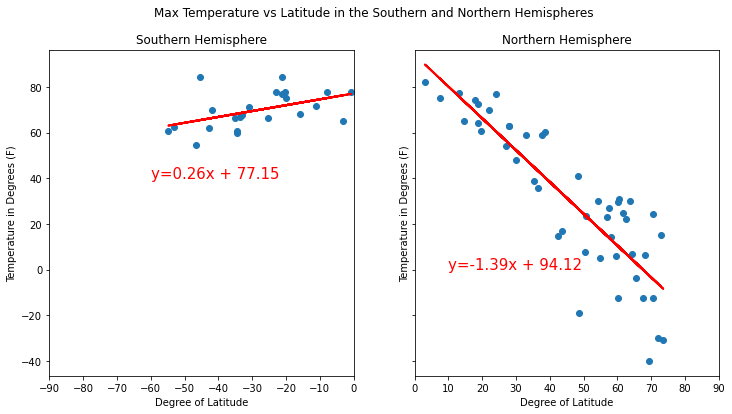

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,6))
fig.suptitle('Max Temperature vs Latitude in the Southern and Northern Hemispheres')
ax1.scatter(xs, ys)
ax1.set_xlim(left=-90, right=0)
ax1.set_title("Southern Hemisphere")
ax1.set(xlabel= "Degree of Latitude", ylabel="Temperature in Degrees (F)")
ax1.plot(xs, regress_s, color='red', linewidth=2)
ax1.annotate(line_eq_s, (-60,40), fontsize=15, color="red")
ax2.scatter(xn, yn)
ax2.set_xlim(left=0, right=90)
ax2.set_title("Northern Hemisphere")
ax2.set(xlabel= "Degree of Latitude", ylabel="Temperature in Degrees (F)")
ax2.plot(xn, regress_n, color="red", linewidth=2)
ax2.annotate(line_eq_n, (10,0), fontsize=15, color="red")
plt.show()

In [35]:
print(f'The r-value of the southern hemisphere is {(rvalue_s)} and the r-value of the northern hemisphere is {rvalue_n}.')

The r-value of the southern hemisphere is 0.48417594447572254 and the r-value of the northern hemisphere is -0.8687631610127396.


In [36]:
# Northern Hemisphere - Humidity (%) vs. Latitude
# Southern Hemisphere - Humidity (%) vs. Latitude

xn2 = weather_north_df["Latitude"]
yn2 = weather_north_df["Humidity (%)"].astype(int)

#calculate regression
(slope_n2, intercept_n2, rvalue_n2, pvalue_n2, stderr_n2) = linregress(xn2, yn2)
regress_n2 = xn2 * slope_n2 + intercept_n2
line_eq_n2 = "y=" + str(round(slope_n2,2)) + "x + " + str(round(intercept_n2,2))
print(line_eq_n2)

y=0.34x + 62.19


In [37]:
xs2 = weather_south_df["Latitude"]
ys2 = weather_south_df["Humidity (%)"].astype(int)

#calculate regression
(slope_s2, intercept_s2, rvalue_s2, pvalue_s2, stderr_s2) = linregress(xs2, ys2)
regress_s2 = xs2 * slope_s2 + intercept_s2
line_eq_s2 = "y=" + str(round(slope_s2,2)) + "x + " + str(round(intercept_s2,2))
print(line_eq_s2)

y=0.59x + 94.52


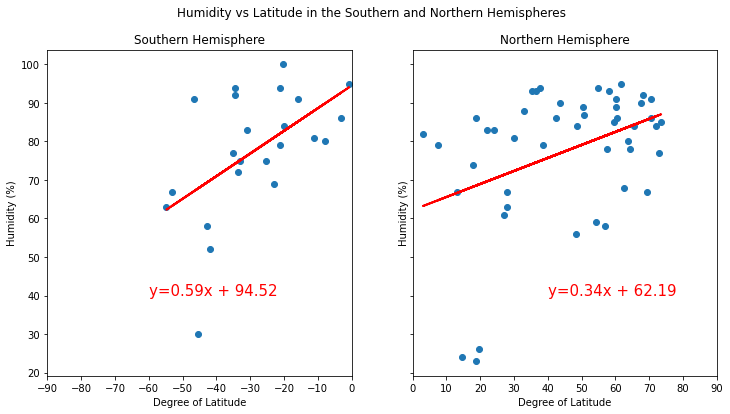

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,6))
fig.suptitle('Humidity vs Latitude in the Southern and Northern Hemispheres')
ax1.scatter(xs2, ys2)
ax1.set_xlim(left=-90, right=0)
ax1.set_title("Southern Hemisphere")
ax1.set(xlabel= "Degree of Latitude", ylabel="Humidity (%)")
ax1.plot(xs2, regress_s2, color='red', linewidth=2)
ax1.annotate(line_eq_s2, (-60,40), fontsize=15, color="red")
ax2.scatter(xn2, yn2)
ax2.set_xlim(left=0, right=90)
ax2.set_title("Northern Hemisphere")
ax2.set(xlabel= "Degree of Latitude", ylabel="Humidity (%)")
ax2.plot(xn2, regress_n2, color="red", linewidth=2)
ax2.annotate(line_eq_n2, (40,40), fontsize=15, color="red")
plt.show()

In [45]:
print(f'The r-value of the southern hemisphere is {(rvalue_s2)} and the r-value of the northern hemisphere is {rvalue_n2}.')

The r-value of the southern hemisphere is 0.5481350604511703 and the r-value of the northern hemisphere is 0.39195545495639705.


In [39]:
# Northern Hemisphere - Cloudiness (%) vs. Latitude
# Southern Hemisphere - Cloudiness (%) vs. Latitude

# define values for northern hemisphere
xn3 = weather_north_df["Latitude"]
yn3 = weather_north_df["Cloudiness"].astype(int)

#calculate regression
(slope_n3, intercept_n3, rvalue_n3, pvalue_n3, stderr_n3) = linregress(xn3, yn3)
regress_n3 = xn3 * slope_n3 + intercept_n3
line_eq_n3 = "y=" + str(round(slope_n3,2)) + "x + " + str(round(intercept_n3,2))
print(line_eq_n3)

y=0.08x + 53.28


In [40]:
#define values for southern hemisphere
xs3 = weather_south_df["Latitude"]
ys3 = weather_south_df["Cloudiness"].astype(int)

#calculate regression
(slope_s3, intercept_s3, rvalue_s3, pvalue_s3, stderr_s3) = linregress(xs3, ys3)
regress_s3 = xs3 * slope_s3 + intercept_s3
line_eq_s3 = "y=" + str(round(slope_s3,2)) + "x + " + str(round(intercept_s3,2))
print(line_eq_s3)

y=1.05x + 82.2


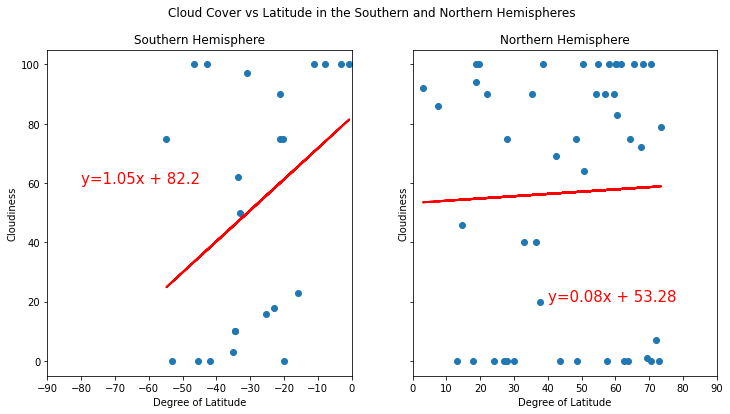

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,6))
fig.suptitle('Cloud Cover vs Latitude in the Southern and Northern Hemispheres')
ax1.scatter(xs3, ys3)
ax1.set_xlim(left=-90, right=0)
ax1.set_title("Southern Hemisphere")
ax1.set(xlabel= "Degree of Latitude", ylabel="Cloudiness")
ax1.plot(xs3, regress_s3, color='red', linewidth=2)
ax1.annotate(line_eq_s3, (-80,60), fontsize=15, color="red")
ax2.scatter(xn3, yn3)
ax2.set_xlim(left=0, right=90)
ax2.set_title("Northern Hemisphere")
ax2.set(xlabel= "Degree of Latitude", ylabel="Cloudiness")
ax2.plot(xn3, regress_n3, color="red", linewidth=2)
ax2.annotate(line_eq_n3, (40,20), fontsize=15, color="red")
plt.show()

In [ ]:
print(f'The r-value of the southern hemisphere is {(rvalue_s3)} and the r-value of the northern hemisphere is {rvalue_n3}.')

In [42]:
# Northern Hemisphere - Wind Speed (mph) vs. Latitude
# Southern Hemisphere - Wind Speed (mph) vs. Latitude

# define values for northern hemisphere
xn4 = weather_north_df["Latitude"]
yn4 = weather_north_df["Wind Speed (mph)"]

#calculate regression
(slope_n4, intercept_n4, rvalue_n4, pvalue_n4, stderr_n4) = linregress(xn4, yn4)
regress_n4 = xn4 * slope_n4 + intercept_n4
line_eq_n4 = "y=" + str(round(slope_n4,2)) + "x + " + str(round(intercept_n4,2))
print(line_eq_n4)

y=-0.02x + 9.92


In [43]:
#define values for southern hemisphere
xs4 = weather_south_df["Latitude"]
ys4 = weather_south_df["Max Temperature (F)"]

#calculate regression
(slope_s4, intercept_s4, rvalue_s4, pvalue_s4, stderr_s4) = linregress(xs4, ys4)
regress_s4 = xs4 * slope_s4 + intercept_s4
line_eq_s4 = "y=" + str(round(slope_s4,2)) + "x + " + str(round(intercept_s4,2))
print(line_eq_s4)

y=0.26x + 77.15


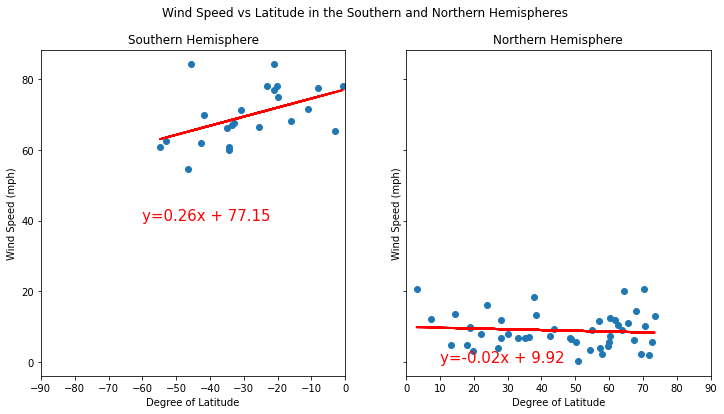

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,6))
fig.suptitle('Wind Speed vs Latitude in the Southern and Northern Hemispheres')
ax1.scatter(xs4, ys4)
ax1.set_xlim(left=-90, right=0)
ax1.set_title("Southern Hemisphere")
ax1.set(xlabel="Degree of Latitude", ylabel="Wind Speed (mph)")
ax1.plot(xs4, regress_s4, color='red', linewidth=2)
ax1.annotate(line_eq_s4, (-60,40), fontsize=15, color="red")
ax2.scatter(xn4, yn4)
ax2.set_xlim(left=0, right=90)
ax2.set_title("Northern Hemisphere")
ax2.set(xlabel= "Degree of Latitude", ylabel="Wind Speed (mph)")
ax2.plot(xn4, regress_n4, color="red", linewidth=2)
ax2.annotate(line_eq_n4, (10,0), fontsize=15, color="red")
plt.show()

In [46]:
print(f'The r-value of the southern hemisphere is {(rvalue_s4)} and the r-value of the northern hemisphere is {rvalue_n4}.')

The r-value of the southern hemisphere is 0.48417594447572254 and the r-value of the northern hemisphere is -0.08843548923208791.


In [ ]:
# After each pair of plots, take the time to explain what the linear regression is modeling. 
# For example, describe any relationships you notice and any other analysis you may have.